## About Dataset


### Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

#### Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [1]:
import os
import kaggle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import zscore, ttest_ind, mannwhitneyu
from ydata_profiling import ProfileReport, compare
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE, ADASYN, KMeansSMOTE

import optuna
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_selection import SelectFromModel 
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lazypredict.Supervised import LazyClassifier

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model, models, backend as K, Sequential
from tensorflow.keras.layers import Dense, Input, Lambda



# Set you API credentioals
kaggle.api.authenticate()

path = "./1. Original Data/"

# check if file exist
if os.path.isfile(path+'creditcard.csv'):
    print('File exists.')
else:
# Download the Credit_Card_Fraud_Detection dataset
    kaggle.api.dataset_download_files('mlg-ulb/creditcardfraud', path=path, unzip=True)
    print('File Downloaded.')

File exists.


In [2]:
# Read the dataset into Pandas dataframe
df = pd.read_csv('./1. Original Data/creditcard.csv')

# display the first 5 instances
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


In [5]:
num_duplicated = df.duplicated().sum()
print(f'There are {num_duplicated} duplicated rows in the dataset')

There are 1081 duplicated rows in the dataset


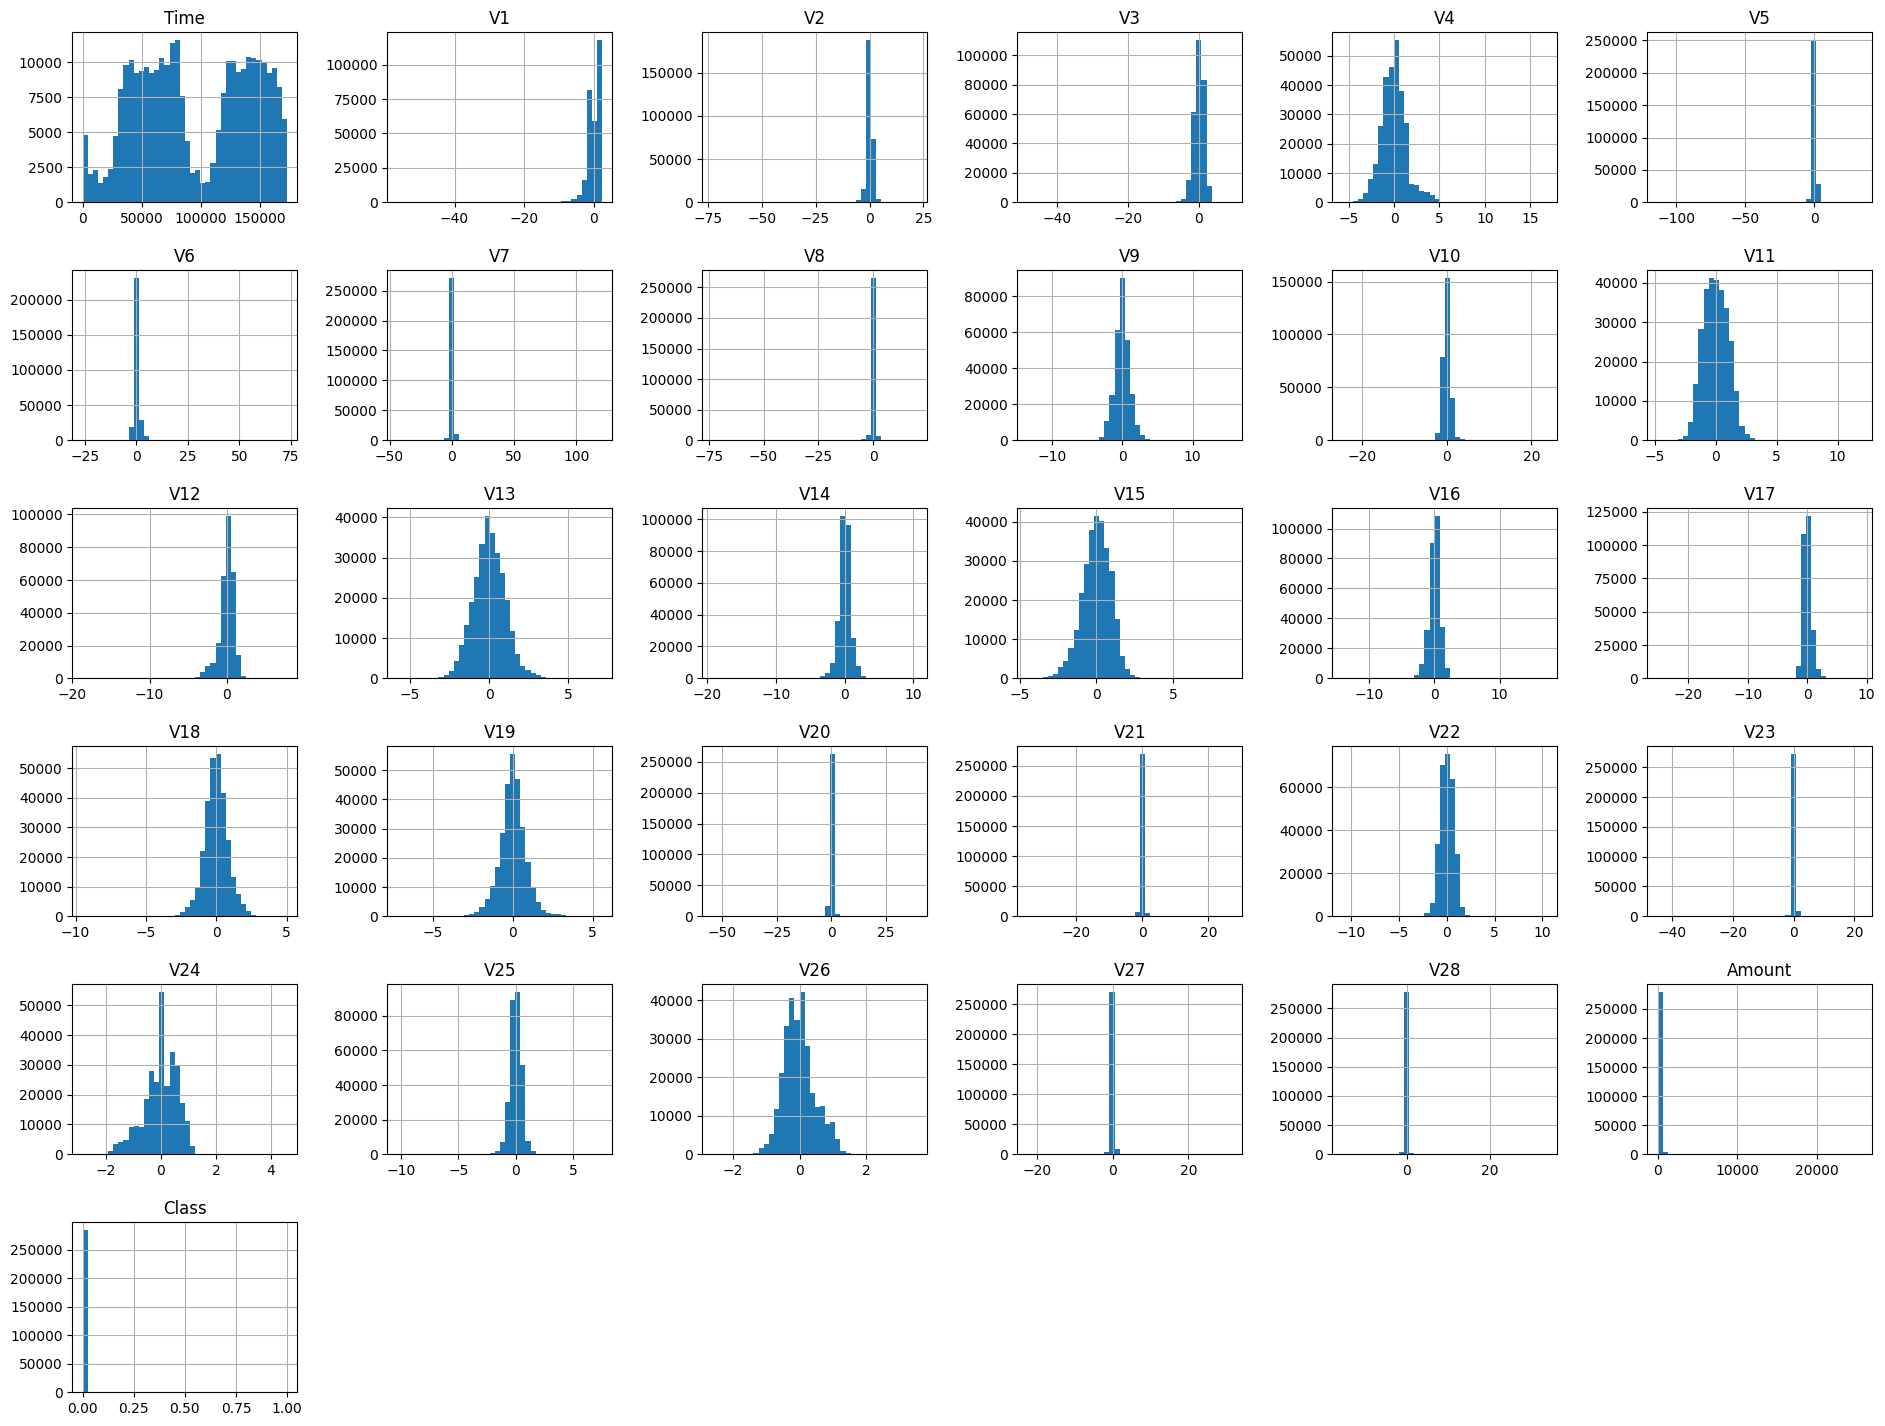

In [6]:
# Plot the histograms in a 6x6 grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(20, 16))
for i, col in enumerate(df.columns):
    ax = axes[i // 6, i % 6]
    df[col].hist(ax=ax, bins=40)
    ax.set_title(col)

# Remove the empty subplots
for i in range(len(df.columns), 36):
    axes[i // 6, i % 6].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.9, wspace=0.4, hspace=0.4)

# Show the plot
plt.show()

In [7]:
def class_percentage(series):
    class_counts = series.value_counts()
    return class_counts, (class_counts / class_counts.sum() * 100).round(2).astype(str).apply(lambda x: x + '%')

In [8]:
class_counts, class_percent = class_percentage(df.Class)
class_percent

0    99.83%
1     0.17%
Name: Class, dtype: object

In [9]:
# # plot showing the count of Unique elements in the employment_type
# fig = px.bar(x=class_counts.index, 
#              y=class_counts.values, 
#              text=class_percent, 
#              template='plotly_dark',
#              color_discrete_sequence=px.colors.qualitative.Safe,
#              title='Class Distribution',
#              labels=dict(x='Class', y='Frequency'));

# fig.update_traces(textposition='outside')
# fig.update_layout(height=600, width=800)
# fig.update_xaxes(categoryorder='array', categoryarray=['No Fraud', 'Fraud'])
# fig.show()

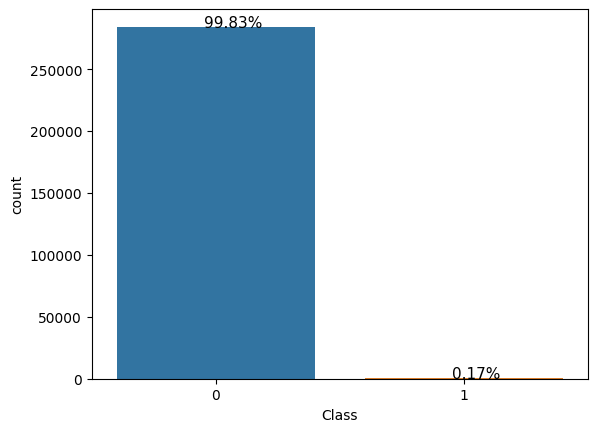

In [10]:
ax = sns.countplot(data=df, x='Class')

# Annotate the bars with their respective percentage
total = float(len(df['Class']))
for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2 - 0.05
    y = p.get_height() + 3
    ax.text(x, y, percentage, fontsize=11)

In [11]:
# Generate a Profile Report for the dataframe
# report = ProfileReport(df)

# # Save the report to a HTML file
# report.to_file('./3. Insights and Viz/CreditCardFraud.html')


# display the report
# display(report)

Assessing the data, we noticed a few things:
- The dataset is made up of 284807 instances (rows) and 31 columns (features + target)
- The dataset has no missing data
- The dataset contians 1081 duplicated roles
- There are 31 columns, 30 of which are continuous variable (`Features`) and a descrete variable (`Target`)
- The target `Class` is binary and is highly imbalanced (99.83% No_Fraund, and 0.17% Fraud)
- Some of the independent features are peaked (high kurtosis) and skewed



Before proceeding further with any data analysis or modeling, it is crucial to split the dataset into a training set and a test set. The training set will be used to carry our Exploratory Data Analysis (EDA), build and train the model, while the test set will be used to evaluate the model's performance on new, unseen data. Argueably, It is important to avoid carrying out EDA on the test set (inclusive) as this could lead to the introduction of bias during the model building phase. To prevent this, the dataset should be split into the training and test sets before any further analysis or preprocessing steps are taken.
**NOTE:** Since the testset come from the same distribution with the training set, result from our analysis carreid out on the trainset should be reflective of the entire dataset during the model building process, as this can introduce bias into the results. 

One important step that can be taken before splitting the dataset is to remove any duplicate entries. Duplicates in the dataset can affect the performance of the model by introducing bias and making it appear as if the model is more accurate than it actually is. However, it is important to note that having duplicates in the training set may affect the model, but having duplicates in the test set will not affect the model's predictions. For this reason, we have decided to drop the duplicates right after the split - in the trainset only.

Another consideration when splitting the dataset is the imbalance nature of the data, which can introduce bias into the split. In our case, we will be using the stratified random sampling method to split the dataset by the Class (target) variable. This method ensures that the proportions of the different classes in both the training and testing sets are preserved, thus reducing the bias introduced by random sampling. let's get on with it>>

In [12]:
# randomly split the dataset into 80% train, 20% test using stratified sampling method
train, test = train_test_split(df, stratify=df['Class'], test_size=0.2, random_state=42)

In [13]:
# drop duplicated rows in the dataframe
train = train.drop_duplicates()

# check for duplicates
train.duplicated().sum()

0

During the process of exploratory data analysis (EDA), it is common to perform various transformations on the data to gain insights and prepare the data for modeling. However, it is important to ensure that these transformations do not alter the original training set, as this can lead to biased model performance. To avoid this issue, we will make a copy of the training set called df_explore. This copy will be used for any transformations or exploratory analysis during EDA, leaving the original training set untouched. Any changes made to df_explore will not affect the original training set and will only be used for exploratory purposes.

In [14]:
df_explore = train.copy()

In the next section, we will be putting on our exploration hat to dig into the dateset to gain further insights.

# Exploratory Data Analysis

From the dataset description, we know that the **V1, V2, V3, ..., V28** features are the result of principal component analysis (PCA) transformation, while the Time and Amount features have not been transformed. This suggests that the Time and Amount features may have unique characteristics that could be informative for our model.

In [15]:
def plot_corr_heatmap(df=df_explore):
    """
    Plots a heatmap of the correlation matrix for a given DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame to plot the correlation matrix for
    
    Returns:
        None
    """
#   Compute correlation
    corr_matrix = df.corr()
    matrix = abs(corr_matrix).unstack()
    # matrix = matrix[matrix.between(0.4 | -0.4, 1, inclusive='neither')]
    matrix = matrix[matrix.between((0.4 or -0.4), (1 or -1), inclusive='neither')]

    
#   Create a boolean mask to hide the upper triangle of the heatmap
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
#   Set style to darkgrid
    # sns.set_style("darkgrid")

#   creates a figure and set its size
    plt.figure(figsize=(25, 15))
#   plot correlation heatmap
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True)
#   render plot()
    plt.show()
    
    print(matrix)


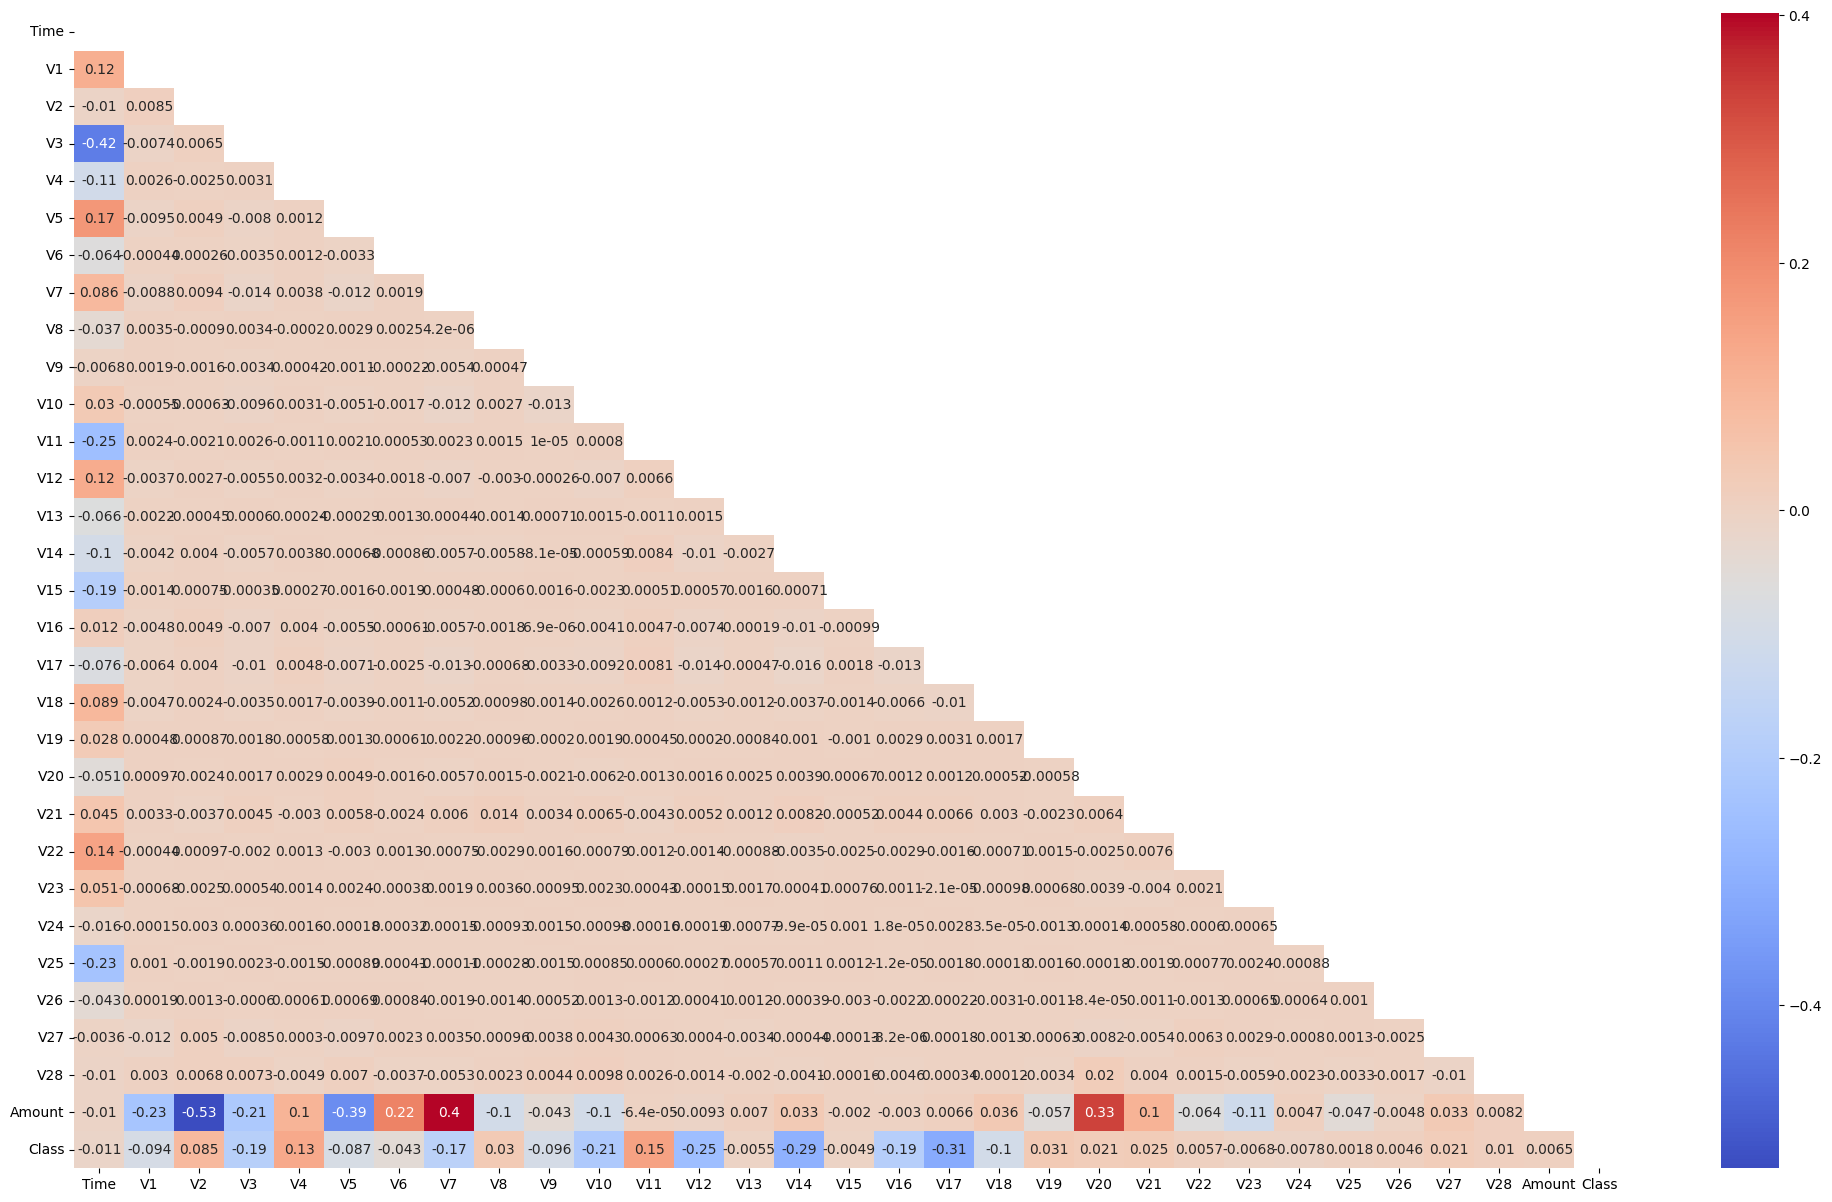

Time    V3       0.42
V2      Amount   0.53
V3      Time     0.42
V7      Amount   0.40
Amount  V2       0.53
        V7       0.40
dtype: float64


In [16]:
plot_corr_heatmap()

from the heatmap, we can spot distinct highlight on some cells, depending on the intensity of coloration, it shows how each of the features (predictors and response) are correlated to each other. The standard heuristic for deciding if the correlation between two features is strong or weak is generally as follows:
- A correlation coefficient (r) between 0 and 0.3 (or -0.3) is considered weak or low.
- A correlation coefficient between 0.3 and 0.7 (or -0.3 and -0.7) is considered moderate or medium.
- A correlation coefficient greater than 0.7 (or less than -0.7) is considered strong or high.

We observe that the Time and Amount features have a moderate correlation with the V3 feature and the (V2, V7) features, respectively. This indicates that there may be some underlying relationship or pattern between these features that could potentially be useful in our modeling process. However, it is important to keep in mind that correlation does not necessarily imply causation, and further analysis is needed to establish any causal relationships between the features. 

Due to confidentiality reasons, the majority of the features in the dataset have been transformed using PCA, and this limits our ability to gain deep insights on these features. However, we still have access to the original untransformed features of Time and Amount, which provide some potential insights into the data. By focusing our exploratory analysis on these features, we can still gain a better understanding of the data and potentially uncover some interesting relationships or patterns. Additionally, by understanding the characteristics of these untransformed features, we may be able to use this information to inform the modeling process and potentially improve the accuracy of our predictions.

### Time

let's start by plotting and understanding the undelying distribution

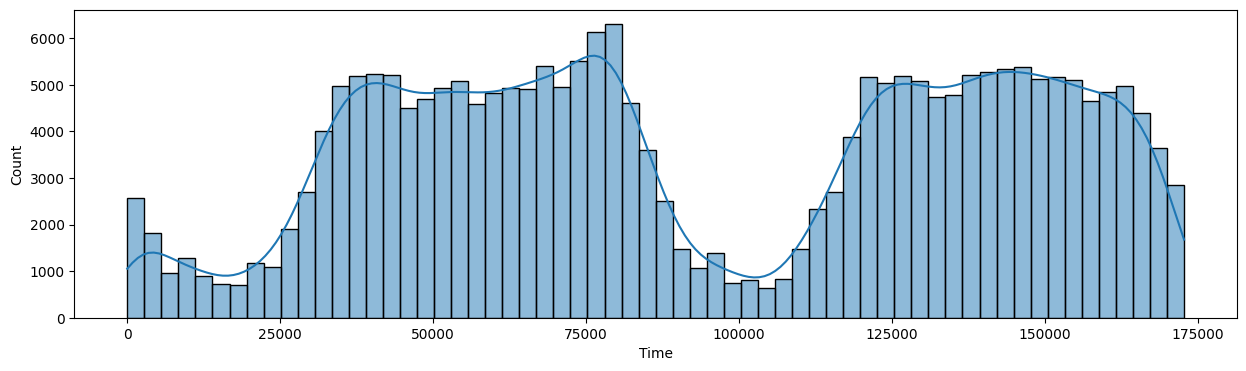

In [17]:
# plots the histogram and distribution of Time
plt.figure(figsize=(15, 4))
sns.histplot(data=df_explore, x='Time', kde=True)
plt.show()

Form the Histogram plot, we can observe that there is a bimodal distribution. One possible explanation for this bimodal distribution is that the data was collected over a two-day window time period, and there may be differences in the transaction behavior during the day versus the night.

To further investigate this pattern, we can plot the histograms of each class separately and observe any differences in the transaction behavior between the two groups. This analysis can provide insights into the factors that contribute to fraudulent activities and help develop effective fraud detection strategies. Additionally, we can use other statistical techniques, such as hypothesis testing and regression analysis, to test our hypotheses and identify the underlying causes of the bimodal distribution in the Time feature.

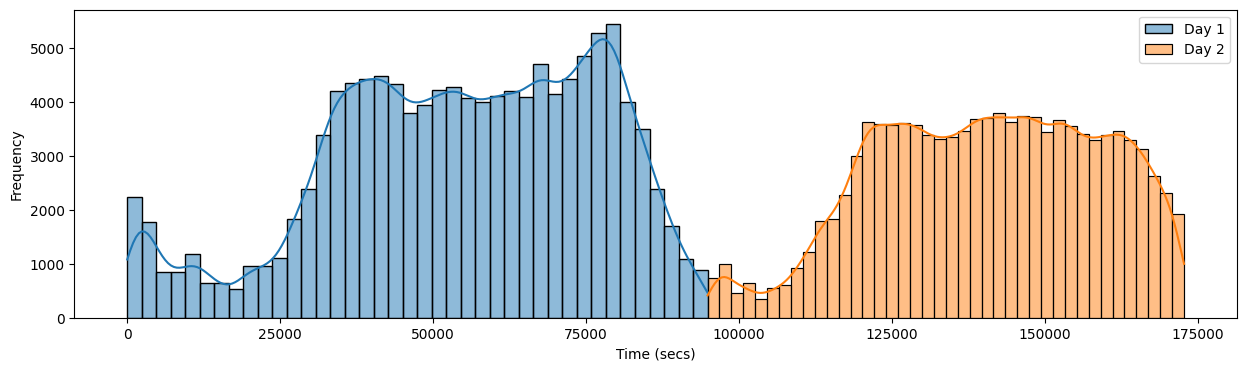

The bimodality in Time feature is significantly different between Day 1 and Day 2 with p-value: 0.0


In [18]:
# Calculate the mean and standard deviation of the Time feature
time_mean = df_explore['Time'].mean()
time_std = df_explore['Time'].std()

# Divide the data into two groups based on whether the time falls within the first 24 hours (Day 1) 
# or the second 24 hours (Day 2) of the 2-day window
day1 = df_explore[df_explore['Time'] <= time_mean]
day2 = df_explore[df_explore['Time'] > time_mean]

# Plot histograms of the two groups separately and compare the distributions visually\
plt.figure(figsize=(15, 4))
sns.histplot(day1['Time'], bins=40, alpha=0.5, kde=True, label='Day 1')
sns.histplot(day2['Time'], bins=40, alpha=0.5, kde=True, label='Day 2')
plt.xlabel('Time (secs)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Perform a statistical test to compare the two groups
stat, p = mannwhitneyu(day1['Time'], day2['Time'])
if p < 0.05:
    print('The bimodality in Time feature is significantly different between Day 1 and Day 2 with p-value:', p)
else:
    print('The bimodality in Time feature is not significantly different between Day 1 and Day 2 with p-value:', p)


The bimodality in the Time feature being significantly different between Day 1 and Day 2 validates that there are two distinct periods of time in the 2-day window with different transaction patterns, leading to two peaks in the histogram plot. However, it is important to note that since the Time feature indicates the time elapsed between the first transaction and subsequent transactions, we cannot conclude that the troughs represent nights and the peaks represent the day. This is because the time zone, location, and individual customer behavior patterns may also contribute to the distribution of transactions. Therefore, we cannot solely rely on the Time feature to determine whether the bimodality is due to day and night patterns. However, we can conclude that the bimodality is significant and is most likely caused by the 2-day window in the data, which can be further investigated using other features and external information.

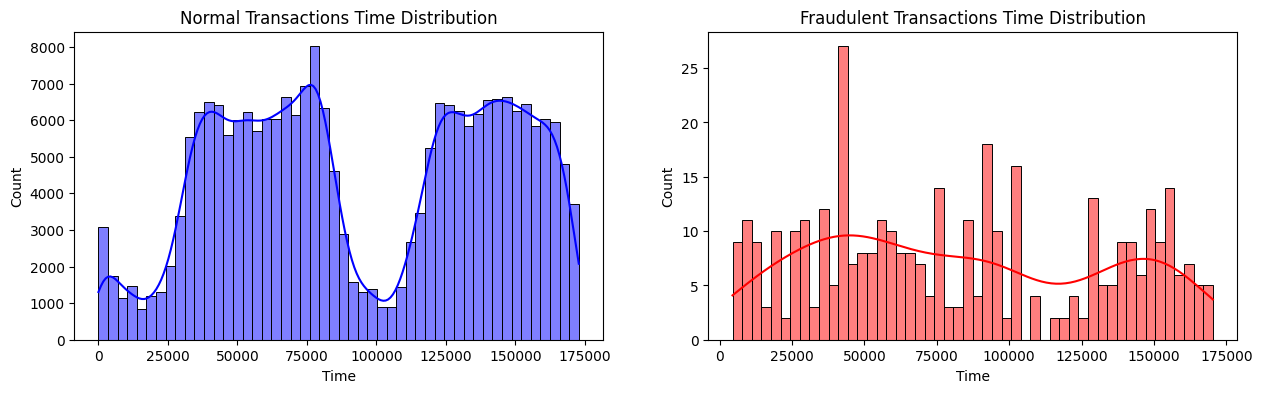

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(data=df_explore[df_explore.Class == 0], x='Time', bins=50, kde=True, color='blue', ax=axs[0]) 
axs[0].set_title('Normal Transactions Time Distribution')
sns.histplot(data=df_explore[df_explore.Class == 1], x='Time', bins=50, kde=True, color='red', ax=axs[1])
axs[1].set_title('Fraudulent Transactions Time Distribution')

plt.show()

The Time distribution of Fraudulent and Normal transactions provides important insights into the temporal behavior of the dataset. When we compare the Normal Time distribution to the overall Time distribution, we notice that they are fairly similar, suggesting that normal transactions follow a similar temporal pattern as the entire `Time` feature in the dataset. However, when we look at the Time distribution of Fraudulent transactions, we see a different pattern. This suggests that Fraudulent transactions exhibit a different temporal behavior than the normal transactions.

To gain more understanding about the distribution of Time feature, let's transform it into hours from seconds. This transformation might allow us to better visualize the temporal patterns in the data, as well as any differences between the normal and fraudulent transactions.

In [20]:
def convert_time_to_hours(df, col='Time'): 
    df_copy = df.copy()  # create a copy of the DataFrame
    df_copy[col] = (df_copy[col] // 3600) % 24
    df_copy = df_copy.rename(columns={col: 'Hours'}).astype({'Hours': int})
    return df_copy

In [21]:
df_explore = convert_time_to_hours(df_explore)
df_explore.head()

,Hours,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
265518,20,1.95,-0.75,-1.36,-0.66,1.50,4.02,-1.48,1.14,1.41,...,0.08,0.30,0.31,0.69,-0.35,-0.39,0.08,-0.03,7.32,0
180305,10,2.04,-0.05,-3.06,0.25,2.94,3.30,-0.00,0.67,0.05,...,0.04,0.23,0.04,0.71,0.51,-0.47,0.00,-0.07,2.99,0
42664,11,-0.99,0.60,0.71,-0.99,-0.83,1.96,-2.21,-5.04,0.00,...,-2.80,0.11,-0.44,-0.93,0.83,0.91,0.04,0.19,175.10,0
198723,12,2.29,-1.50,-0.75,-1.67,-1.39,-0.35,-1.43,0.01,-1.12,...,-0.14,0.08,0.21,-0.54,-0.28,-0.16,0.02,-0.06,6.10,0
82325,16,-0.45,-1.01,0.12,-3.45,0.72,-0.15,0.50,-0.11,-0.04,...,-0.24,-0.17,-0.01,-1.36,-0.29,-0.14,-0.03,-0.06,86.10,0


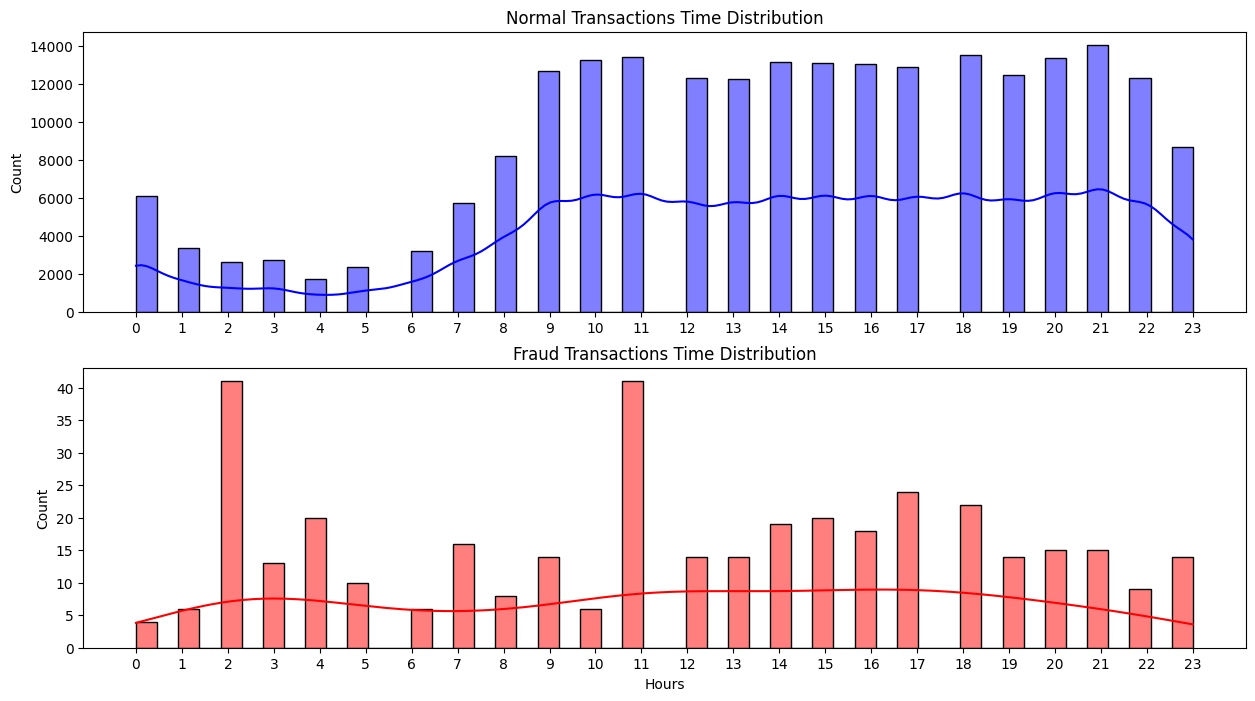

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))

sns.histplot(data=df_explore[df_explore.Class == 0], x='Hours', bins=50, kde=True, color='blue', ax=axs[0]) 
axs[0].set_title('Normal Transactions Time Distribution')
axs[0].set_xticks(range(24))
axs[0].set_xlabel('')

sns.histplot(data=df_explore[df_explore.Class == 1], x='Hours', bins=50, kde=True, color='red', ax=axs[1])
axs[1].set_title('Fraud Transactions Time Distribution')
axs[1].set_xticks(range(24))

plt.show()

From the plot, we can observe that the number of transactions starts declining evenly from the first hour (tagged 0) and continues to decline till the fourth hour. After the fourth hour, there is a uniform increase in the number of transactions till the ninth hour, indicating that there was a period of increased transaction activity. Following this, the number of transactions remains fairly stable, with a slightly alternating constant curve, till the twentieth hour. From the twentieth hour, the curve starts to plateau, indicating a slowdown in transaction activity.
Based on this observation, it can be inferred that the normal transaction activity followed a distinct pattern, with a decline in activity in the early hours, followed by a period of increased activity from the fifth to the ninth hour, and then a relatively stable transaction activity till the twentieth hour.

In contrast to the normal transaction activity, the fraudulent activity showed a different pattern. The fraudulent activity curve started increasing uniformly from the first hour and remained relatively uniform through the entire hour marks, with two significant peaks at the 2nd hour and 11th hour. This indicates that a high volume of credit card fraud occurred at these hours.

However, it is important to note that this pattern is only based on the Time feature and does not necessarily indicate a causal relationship between time of day and fraudulent activity. It is also possible that other factors such as location, type of transaction, and individual customer behavior patterns may contribute to the observed patterns. Therefore, further investigation using other features and external information is necessary to confirm whether the observed pattern is due to time-based factors or other factors.

### Amount

let's visualize the histogram of the Amount feature in log scale

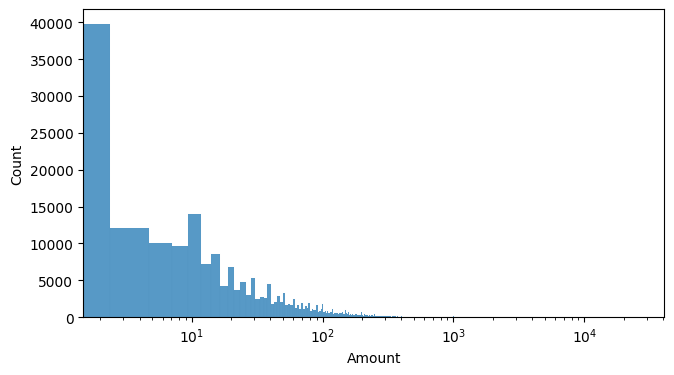

In [23]:
plt.figure(figsize=(7.5, 4))
sns.histplot(data=df_explore, x='Amount').set(xscale='log')
plt.show()

The plot shows that the distribution of the `Amount` feature is highly skewed to the right, even when we apply a logarithmic transformation. This means that the majority of the transactions have lower amounts, while a small percentage of transactions have significantly higher amounts. This could indicate that the dataset has a high number of low-value transactions and a small number of high-value transactions. We can verify this ny counting the frequencies of each figure in the `Amount`, repectively.

To further investigate the distribution of `Amount`, Let's plot the feature `Amount` with respect to the target `Class`. we can generate a histogram or density plot for each class separately. This will help us determine whether there is a difference in the distribution of `Amount` between the fraudulent and non-fraudulent (Normal) transactions; If there is a significant difference in the distribution of `Amount` between the two classes, it could indicate that the`Amount` feature is a useful predictor for detecting fraud. However, if there is no significant difference or if the distribution of Amount' is similar for both classes, then Amount' may not be a useful feature for detecting fraud. Therefore, it is important to investigate the relationship between `Amount` and the target `Class` to determine whether the feature should be included in the model and whether any transformations or normalization techniques should be applied to mitigate the effect of skewness.

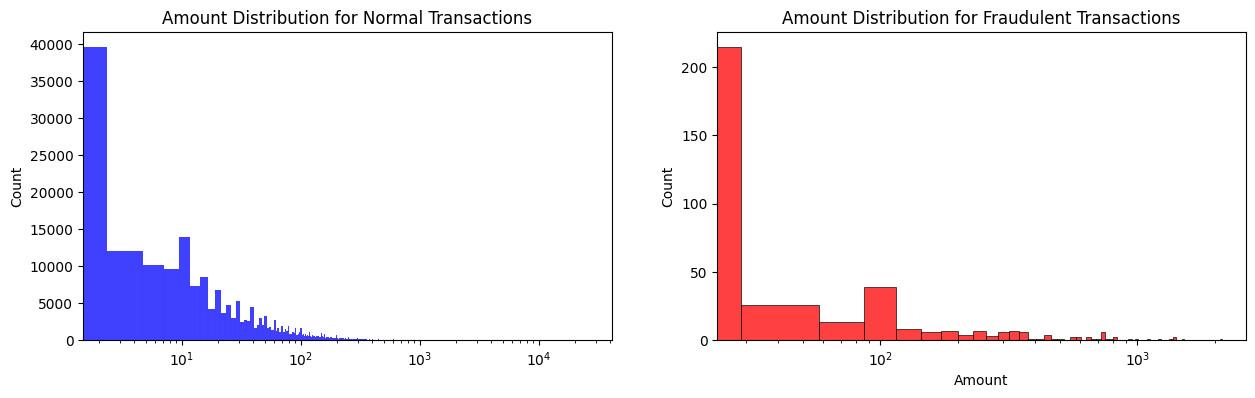

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(data=df_explore[df_explore['Class'] == 0], x='Amount', color='blue', ax=axs[0]).set(xscale='log')
axs[0].set_title('Amount Distribution for Normal Transactions')
axs[0].set_xlabel('')
sns.histplot(data=df_explore[df_explore['Class'] == 1], x='Amount', color='red', ax=axs[1]).set(xscale='log')
axs[1].set_title('Amount Distribution for Fraudulent Transactions')
plt.show()

The plot shows that the distribution of the `Amount` feature is highly skewed to the right, even after separating the data into the fraudulent and non-fraudulent transactions. This indicates that the skewness of the `Amount` feature is not solely due to the presence of fraudulent transactions in the dataset, suggesting that, countrary to what we wouuld expect that the majority of the fraudulent transactions will be high amount (skewing the data to the left), majority of the fraudulent amount are relative low. This is interesting, let's investigate this a little further. 


Interestingly, the skewness of the Amount feature is not solely due to the presence of fraudulent transactions in the dataset. In fact, the majority of the fraudulent transactions have relatively low amounts (as we can see on the right histogram plot, having its highest bar at the origin), which is counterintuitive since one might expect fraudulent transactions to have high amounts. This observation raises important questions about the characteristics of fraudulent transactions and how they differ from normal transactions. Let's investigate this a little further.


In [25]:
top_10_fraud_amounts = df_explore[df_explore['Class'] == 1]['Amount'].value_counts(ascending=False).head(10)
top_10_amounts = top_10_fraud_amounts.index.tolist()


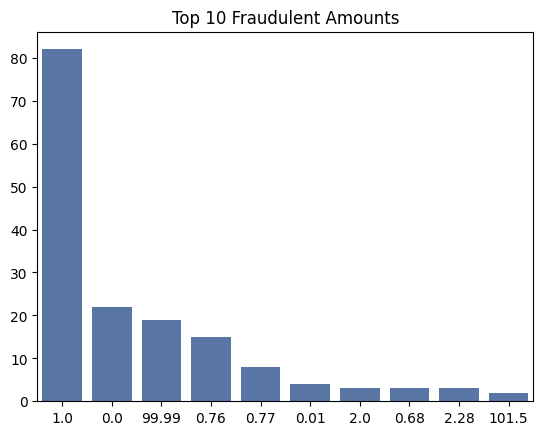

In [26]:
sns.barplot(x=top_10_fraud_amounts.index, y=top_10_fraud_amounts.values, color='#4C72B0', order=top_10_amounts)
plt.title('Top 10 Fraudulent Amounts')
plt.show()

From the barplot, we see that amount of 0.0 was considered as fraud in the dataset. The reason behind this is ambiguous, especially in the  context this analysis. In general, it is not common for legitimate transactions to have an amount of exactly 0.0, as even small fees or taxes would result in a non-zero amount. Intuitively, we can say that an amount of 0.0 may be used as a flag for potentially fraudulent transactions or anomalies. Additionally, it is possible that some fraudsters intentionally set the amount to 0.0 in an attempt to evade detection or to test stolen credit card information before using it for larger transactions. In addition, we see from the plot that the majority of fraudulent transactions have relatively small amounts, with the highest frequency occurring at around 1. This suggests that fraudsters tend to make small fraudulent transactions rather than large ones, which makes sense as larger transactions may be subject to more scrutiny and are more likely to trigger fraud detection systems.

To mitigate the effect of skewness on the `Amount` feature and all other features, we will be using the sklearn **PowerTransformer** feature transformation techniques. This technique can help to normalize the distribution of all the features with distributions other than Gaussian distribution.

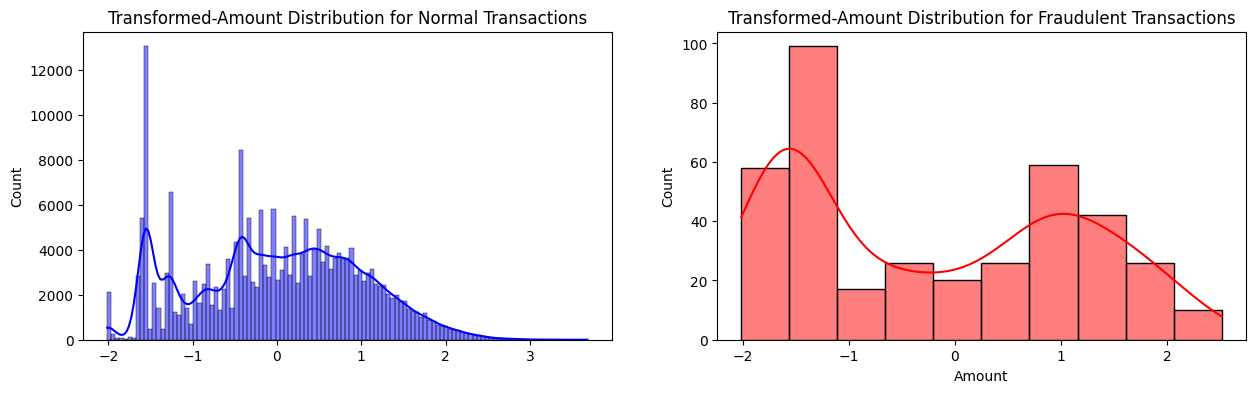

In [27]:
# creates an instance of the PowerTransformer, using the yeo-johnson method, to mormaize the Amount
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# fit and transform all the features but Hour and Class features
df_explore.iloc[:, 1:-1] = pt.fit_transform(df_explore.iloc[:, 1:-1])

# reset the index of the transformed dataset
df_explore = df_explore.reset_index(drop=True)

# view the first few rows of the transformed dataset
# df_explore.head()

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(data=df_explore[df_explore['Class'] == 0], kde=True, x='Amount', color='blue', ax=axs[0])
axs[0].set_title('Transformed-Amount Distribution for Normal Transactions')
axs[0].set_xlabel('')
sns.histplot(data=df_explore[df_explore['Class'] == 1], x='Amount', kde=True, color='red', ax=axs[1])
axs[1].set_title('Transformed-Amount Distribution for Fraudulent Transactions')
plt.show()

The yeo-johnson method is a powerful transformation technique used to normalize data. It is similar to the well-known Box-Cox transformation method, but unlike Box-Cox, it can handle both positive and negative values, making it a more versatile option.
When applied to the Amount feature using the sklearn PowerTransformer instance, the distribution of the Amount feature is transformed. Although the transformed curve may not be a perfect bell curve, we can observe that it bears a remarkable resemblance to the Gaussian distribution curve, which is a normal distribution curve.

Normality is important for many machine learning models, including linear regression and logistic regression, which assume that the data follow a normal distribution. By transforming the data to a normal distribution using techniques like the yeo-johnson method, we can make it easier to apply these models and obtain more accurate results. In the next section of this Kernel, we will be using the yeo-johnson method to transform the entire dataset, except for the Hour feature, which we previously transformed using a simpler technique.

### Bivariate Analysis

After conducting a Univariate analysis of the Time and Amount features, we can now move on to exploring the relationship between these features using a boxplot. By using a boxplot, we can visually inspect the distribution of the two features and compare them side by side to identify any patterns or outliers in the data. This analysis can help us gain insights into the behavior of these features and identify any potential relationships between them that could be useful in our modeling process.

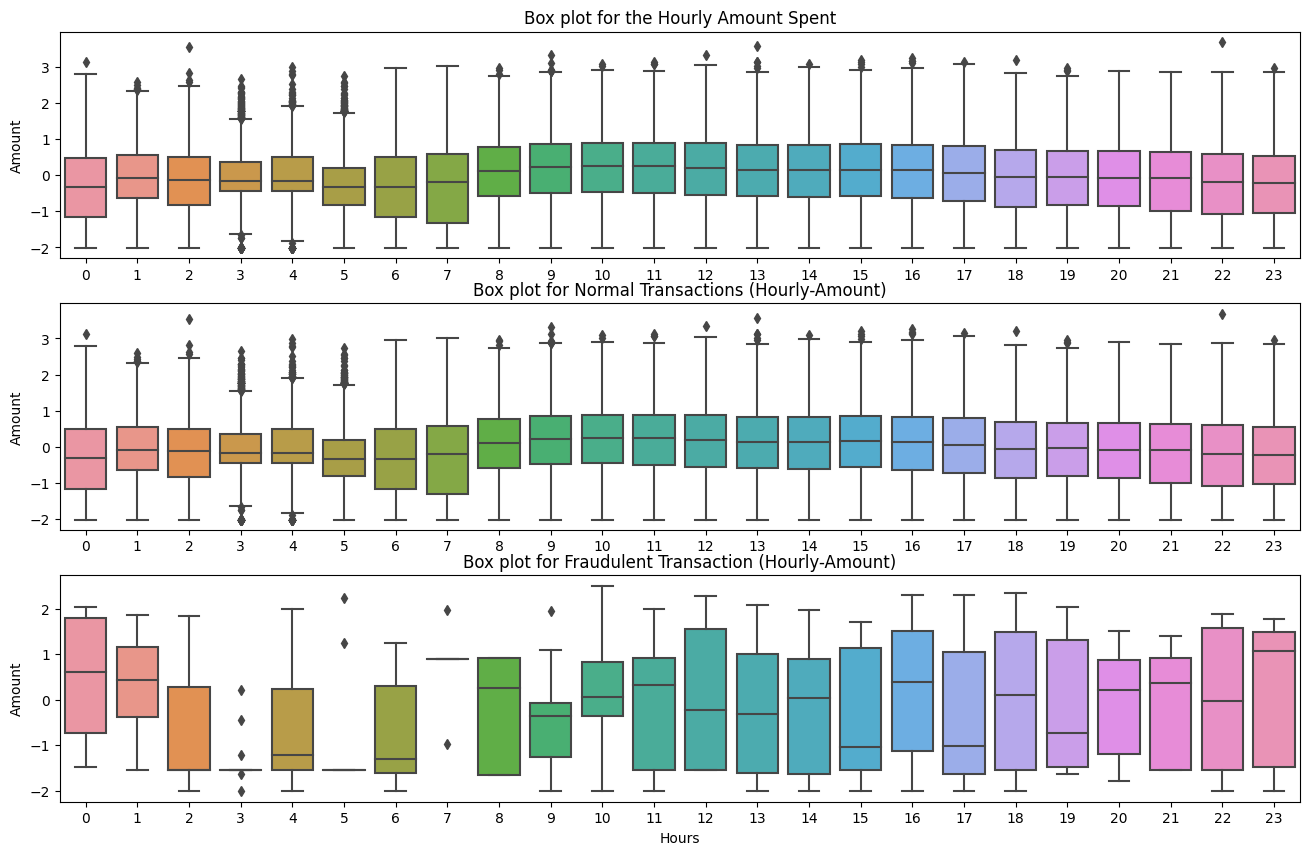

In [28]:
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
sns.boxplot(data=df_explore, x='Hours', y='Amount', ax=axs[0])
axs[0].set_title('Box plot for the Hourly Amount Spent')
axs[0].set_xlabel('')
sns.boxplot(data=df_explore[df_explore['Class'] == 0], x='Hours', y='Amount', ax=axs[1])
axs[1].set_title('Box plot for Normal Transactions (Hourly-Amount)')
axs[1].set_xlabel('')
sns.boxplot(data=df_explore[df_explore['Class'] == 1], x='Hours', y='Amount', ax=axs[2])
axs[2].set_title('Box plot for Fraudulent Transaction (Hourly-Amount)')

plt.show()

The boxplot analysis of the Amount feature with respect to the Time feature revealed that there are a lot of outliers spread throughout the 24 hours. However, when we examined the Amount feature more closely in relation to the Class feature, we found that both Fraud and Normal transactions contain outliers. While the number of outliers seems to be fewer in the Fraud class compared to the Normal class, this could be due to the class imbalance issue where we have a much smaller number of Fraud observations compared to the Normal observations. This suggests that the outliers may not be indicative of fraudulent behavior alone, and may be present in both types of transactions. Hence, further investigation is needed to determine the reason for the presence of outliers in the Amount feature, and whether they should be treated as genuine or erroneous observations.

To investigate the presence of outliers in the other features, we can write a function that uses the z-score to detect outliers. An observation is typically depicted as an outlier, using z-score, if it falls beyond ±3 standard deviations from the mean (i.e., z-score > 3 or z-score < -3).

In [29]:
def outliers_detection(data, threshold=3):
    """For each feature column in the dataset, the function calculates 
    the z-scores and identifies/prints the number of outliers
    
    Parameters
    ----------
    data : pandas.DataFrame
        A dataset
    threshold : int or float
        The threshold at which a value is an outlier.
        Default is 3, which corresponds to ±3σ from the mean.
        
    Returns
    -------
    None
    """
    print(f"At ±{threshold} standard deviation from the mean:")
    
    for col in data.columns[:-1]:
        var = data[col]
        z_scores = zscore(var)
        outliers = var[abs(z_scores) > threshold]
        
        if not outliers.empty:
            print(f"\t- {col} variable contains: {len(outliers)} outliers")
            if len(outliers) < 10:
                print(outliers.values)
        else:
            print(f"\t- No outliers detected for the {col} variable")


In [30]:
outliers_detection(df_explore)

At ±3 standard deviation from the mean:
	- No outliers detected for the Hours variable
	- V1 variable contains: 906 outliers
	- V2 variable contains: 3870 outliers
	- V3 variable contains: 1065 outliers
	- V4 variable contains: 1415 outliers
	- V5 variable contains: 2328 outliers
	- V6 variable contains: 1558 outliers
	- V7 variable contains: 2692 outliers
	- V8 variable contains: 3865 outliers
	- V9 variable contains: 1662 outliers
	- V10 variable contains: 2611 outliers
	- V11 variable contains: 540 outliers
	- V12 variable contains: 1168 outliers
	- V13 variable contains: 862 outliers
	- V14 variable contains: 2637 outliers
	- V15 variable contains: 739 outliers
	- V16 variable contains: 1248 outliers
	- V17 variable contains: 2639 outliers
	- V18 variable contains: 1347 outliers
	- V19 variable contains: 2712 outliers
	- V20 variable contains: 3693 outliers
	- V21 variable contains: 3282 outliers
	- V22 variable contains: 952 outliers
	- V23 variable contains: 2729 outliers
	- V24 

At this point, we have to be careful on our decision whether or not to remove the outliers because a wrong choice may either lead to loss of valuable information or add a significant bias to our model.

Dimensionality reduction techniques can help us visualize high-dimensional data in a lower-dimensional space. By reducing the dimensionality of the data, we can visualize the relationships between different features and get a better understanding of the structure of the data. The t-distributed Stochastic Neighbor Embedding (t-SNE) is one handy technique used to visualize dataset in a 2D plane. This can help us identify any patterns or clusters in the data that may not be apparent in the high-dimensional space.

Once we have a better understanding of the structure of the data, we can make a more informed decision about whether or not to remove outliers. If the outliers are part of a distinct cluster or pattern in the data, removing them may result in a loss of important information. On the other hand, if the outliers are simply noise or errors in the data, removing them may improve the performance of our model.

In [31]:
def plot_tsne(data, n_sample, random_state=42):
    
    # Sample 20,000 non-fraud instances and all fraud instances
    non_fraud_data = data[data['Class'] == 0].sample(n=n_sample, random_state=random_state)
    fraud_data = data[data['Class'] == 1]

    # Combine the subsamples into a single dataframe
    subsample = pd.concat([non_fraud_data, fraud_data], axis=0)

    # Separate the features from the target variable
    X = subsample.drop(['Class'], axis=1)
    y = subsample['Class'].replace({0:'Non-fraud', 1:'Fraud'})

    # creates a TSNE instance, fit and transfore the dataframe
    X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X)

    # Create a scatter plot of the t-SNE visualization
    plt.figure(figsize=(15, 8))
    sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='bright')

    # Add title and axis labels
    plt.title('t-SNE Visualization of Credit Card Transactions', fontsize=16)
    plt.xlabel('t-SNE Component 1', fontsize=14)
    plt.ylabel('t-SNE Component 2', fontsize=14)

    # Display the plot
    plt.show()

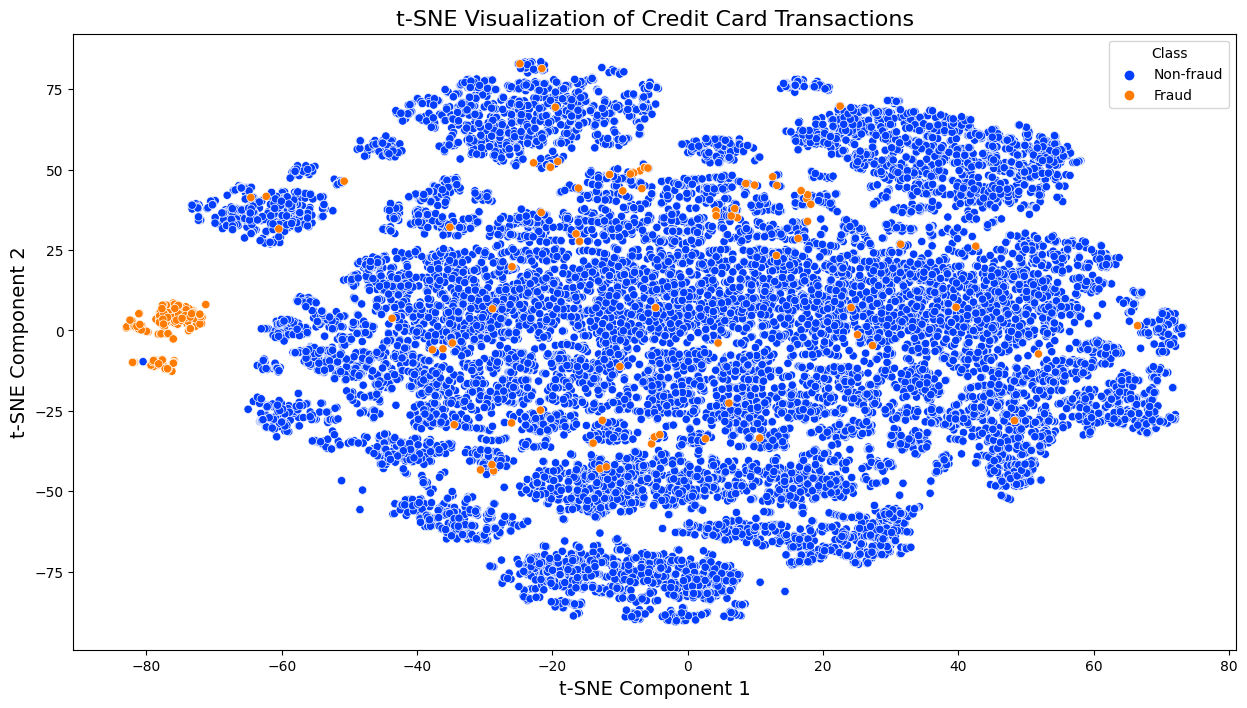

In [32]:
plot_tsne(df_explore, 20000)

After collapsing the dimensions to 2D and plotting, we don't see a clear separation or distinct cluster between the non-fraud and the fraud classes. This implies that removing outliers from the dataset would result in losing valuable information. Therefore, dropping outliers is not a good approach to address class imbalance. Instead, we may need to use another approach, such as autoencoder, to learn latent representations about the dataset and reduce the dimensionality. 

And this wraps up EDA

# Modelling

## Data Preprocessing

In this section, we will be applying several pre-processing steps to our training data using a pipeline. However, before we proceed, we need to create a validation set with the same sample proportion as our test set. This step is crucial because we want our validation set to come from the same distribution as our test set and also have the same class proportion as our test set. By doing this, we can ensure that our validation set is representative of the real-world data that our model will be applied to. Additionally, having a validation set allows us to evaluate the performance of our model during training and make any necessary adjustments to improve its performance before applying it to the test set.

In [36]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('Class', axis=1), train['Class'],
                                                 stratify=train['Class'],test_size=0.2, random_state=42)

In [37]:
# use the convert_time_to_hours to transform 'Time' to Hours in a pipeline
def hour_cat_pipeline():
    return Pipeline(steps=[('hour_pipeline', FunctionTransformer(func=convert_time_to_hours))])

# creates a numerical transformer pipeline
num_pipeline = Pipeline(steps=[('scaler', MinMaxScaler())])

# Combine the transformers with the ColumnTransformer
transformers = [('time', hour_cat_pipeline(), ['Time']),
                ('num', num_pipeline, X_train.columns[1:])]
preprocessor = ColumnTransformer(transformers=transformers)


## Dimensionaly Reduction With AutoEncoders (Variational)

**What are autoencoders:** Autoencoders are neural networks that are designed to learn a compressed representation of input data. They consist of an encoder that takes the input data and maps it to a lower-dimensional representation, and a decoder that takes the compressed representation and maps it back to the original data space. The goal of training an autoencoder is to minimize the reconstruction error, which measures how well the decoder can reconstruct the original input data from the compressed representation. By doing so, autoencoders can be used for data compression and noise reduction.

Variational Autoencoders (VAEs) are a type of autoencoder perform variational Bayesian inference, which is an efficient
way of carrying out approximate Bayesian inference that adds a probabilistic interpretation to the model. VAEs use a similar encoder-decoder architecture as autoencoders, but they introduce a stochastic layer between the encoder and decoder, called the "latent space" or "latent code". In VAEs, the encoder maps the input data to a distribution over the latent space instead of a single point, and the decoder generates new samples by drawing from the latent space distribution. The objective of training a VAE is to maximize the evidence lower bound (ELBO), which consists of two terms: the reconstruction loss and the KL divergence between the distribution over the latent space and a prior distribution. By doing so, VAEs can generate new samples by sampling from the learned latent space distribution, and they can be used for tasks such as data generation and anomaly detection.

In [108]:
# from tensorflow.keras.regularizers import l1


# ## input layer 
# input_layer = Input(shape=(Xnew.shape[1],))

# ## encoding part
# encoded = Dense(100, activation='tanh', activity_regularizer=l1(10e-5))(input_layer)
# encoded = Dense(50, activation='relu')(encoded)

# ## decoding part
# decoded = Dense(50, activation='tanh')(encoded)
# decoded = Dense(100, activation='tanh')(decoded)

# ## output layer
# output_layer = Dense(Xnew.shape[1], activation='relu')(decoded)

In [109]:
# autoencoder = Model(input_layer, output_layer)
# autoencoder.compile(optimizer="adam", loss="mse")

In [110]:
# preprocessor.fit(X_train)
# Xnew = preprocessor.transform(X_train)
# Xval = preprocessor.transform(X_val)

In [111]:
Xnew.shape

NameError: name 'Xnew' is not defined

In [42]:
# class VariationalAutoencoder:
#     def __init__(self, input_dim, latent_dim, intermediate_dim):
#         self.input_dim = input_dim
#         self.latent_dim = latent_dim
#         self.intermediate_dim = intermediate_dim
        
#         self.encoder, self.encoder_mean, self.encoder_log_var = self.build_encoder()
#         self.decoder = self.build_decoder()
#         self.vae = self.build_vae()
        
#     def build_encoder(self):
#         inputs = Input(shape=(self.input_dim,))
        
#         x = inputs
#         for dim in self.intermediate_dim:
#             x = Dense(dim, activation='relu')(x)
        
#         z_mean = Dense(self.latent_dim)(x)
#         z_log_var = Dense(self.latent_dim)(x)

#         def sampling(args):
#             z_mean, z_log_var = args
#             epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.)
#             return z_mean + K.exp(z_log_var / 2) * epsilon

#         z = Lambda(sampling, output_shape=(self.latent_dim,))([z_mean, z_log_var])
#         encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
#         return encoder, z_mean, z_log_var
    
#     def build_decoder(self):
#         latent_inputs = Input(shape=(self.latent_dim,))
#         x = latent_inputs
#         for dim in reversed(self.intermediate_dim):
#             x = Dense(dim, activation='relu')(x)
#         outputs = Dense(self.input_dim, activation='linear')(x)
#         decoder = Model(latent_inputs, outputs, name='decoder')
#         return decoder
    
#     def build_vae(self):
#         inputs = Input(shape=(self.input_dim,))
#         z_mean, z_log_var, z = self.encoder(inputs)
#         outputs = self.decoder(z)
        
#         # Define the loss function
#         def vae_loss(inputs, outputs):
#             reconstruction_loss = K.sum(K.square(inputs - outputs), axis=-1)
#             kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#             return K.mean(reconstruction_loss + kl_loss)
        
#         vae = Model(inputs, outputs, name='vae')
#         vae.add_loss(vae_loss(inputs, outputs))
#         return vae


In [43]:
vae = VariationalAutoencoder(new_xtrain.shape[1], 15, [64, 32])
vae_model = vae.vae
vae_model.compile(optimizer='adam')

In [45]:
history = vae_model.fit(new_xtrain, new_xtrain, epochs=10, batch_size=128,
                             validation_data=(new_xval, new_xval), verbose=1)

Epoch 1/10
1420/1420 [==============================] - 7s 4ms/step - loss: 0.4431 - val_loss: 0.1166
Epoch 2/10
1420/1420 [==============================] - 5s 3ms/step - loss: 0.1156 - val_loss: 0.1146
Epoch 3/10
1420/1420 [==============================] - 5s 3ms/step - loss: 0.1149 - val_loss: 0.1145
Epoch 4/10
1420/1420 [==============================] - 5s 3ms/step - loss: 0.1149 - val_loss: 0.1145
Epoch 5/10
1420/1420 [==============================] - 5s 3ms/step - loss: 0.1148 - val_loss: 0.1145
Epoch 6/10
1420/1420 [==============================] - 5s 3ms/step - loss: 0.1147 - val_loss: 0.1145
Epoch 7/10
1420/1420 [==============================] - 5s 3ms/step - loss: 0.1146 - val_loss: 0.1142
Epoch 8/10
1420/1420 [==============================] - 5s 3ms/step - loss: 0.1145 - val_loss: 0.1140
Epoch 9/10
1420/1420 [==============================] - 5s 4ms/step - loss: 0.1145 - val_loss: 0.1140
Epoch 10/10
1420/1420 [==============================] - 5s 3ms/step - loss: 0.114

In [39]:
class VariationalAutoencoder(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, latent_dim, intermediate_dim, epochs, batch_size):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.intermediate_dim = intermediate_dim
        self.encoder, self.encoder_mean, self.encoder_log_var = self.build_encoder()
        self.decoder = self.build_decoder()
        self.vae = self.build_vae()
        
    def build_encoder(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs
        for dim in self.intermediate_dim:
            x = Dense(dim, activation='relu')(x)
        z_mean = Dense(self.latent_dim)(x)
        z_log_var = Dense(self.latent_dim)(x)

        def sampling(args):
            z_mean, z_log_var = args
            epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.)
            return z_mean + K.exp(z_log_var / 2) * epsilon

        z = Lambda(sampling, output_shape=(self.latent_dim,))([z_mean, z_log_var])
        encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        return encoder, z_mean, z_log_var
    
    def build_decoder(self):
        latent_inputs = Input(shape=(self.latent_dim,))
        x = latent_inputs
        for dim in reversed(self.intermediate_dim):
            x = Dense(dim, activation='relu')(x)
        outputs = Dense(self.input_dim, activation='linear')(x)
        decoder = Model(latent_inputs, outputs, name='decoder')
        return decoder
    
    def build_vae(self):
        inputs = Input(shape=(self.input_dim,))
        z_mean, z_log_var, z = self.encoder(inputs)
        outputs = self.decoder(z)
        
        # Define the loss function
        def vae_loss(inputs, outputs):
            reconstruction_loss = K.sum(K.square(inputs - outputs), axis=-1)
            kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            return K.mean(reconstruction_loss + kl_loss)
        
        vae = Model(inputs, outputs, name='vae')
        vae.add_loss(vae_loss(inputs, outputs))
        vae.compile(optimizer='adam')
        return vae
    
    def fit(self, X, y=None):
        self.vae.fit(X, X, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self
    
    def transform(self, X):
        _, _, codings = self.encoder.predict(X)
        return codings

In [45]:
class VariationalAutoencoderSampler(VariationalAutoencoder):
    def __init__(self, input_dim=X_train.shape[1], latent_dim=15, intermediate_dim=[16], epochs=15, batch_size=128, minority_class_label=0, sample_ratio=1):
        super().__init__(input_dim, latent_dim, intermediate_dim, epochs, batch_size)
        self.minority_class_label = minority_class_label
        self.sample_ratio = sample_ratio
        
    def fit(self, X, y):
        X_minority = X[y == self.minority_class_label]
        super().fit(X_minority)
        return self
    
    def transform(self, X):
        minority_indices = np.where(y == self.minority_class_label)[0]
        if len(minority_indices) == 0:
            return X
        
        majority_indices = np.where(y != self.minority_class_label)[0]
        majority_sample_size = int(len(minority_indices) * self.sample_ratio)
        majority_sample_indices = np.random.choice(majority_indices, size=majority_sample_size, replace=False)
        
        new_X_minority = super().encode(X[minority_indices])
        new_X_majority = super().encode(X[majority_sample_indices])
        new_X = np.concatenate((X, super().decode(new_X_minority), super().decode(new_X_majority)))
        new_y = np.concatenate((y, np.full(len(new_X_minority), self.minority_class_label), y[majority_sample_indices]))
        
        shuffled_indices = np.random.permutation(len(new_X))
        new_X = new_X[shuffled_indices]
        new_y = new_y[shuffled_indices]
        
        return new_X, new_y


In [48]:
pipeline_steps = [('preprocessor', preprocessor),
                  ('vae_sampler', VariationalAutoencoderSampler(epochs=10, intermediate_dim=[30, 16])),
                 ('classifier', XGBClassifier())]
pipeline = Pipeline(steps=pipeline_steps)

In [49]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('time',
                                                  Pipeline(steps=[('hour_pipeline',
                                                                   FunctionTransformer(func=<function convert_time_to_hours at 0x000001E4910241F0>))]),
                                                  ['Time']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V1...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [51]:
y_pred = pipeline.predict(X_val)
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45367
           1       0.73      0.95      0.82        59

    accuracy                           1.00     45426
   macro avg       0.86      0.97      0.91     45426
weighted avg       1.00      1.00      1.00     45426



# Model Building and Training

In [34]:
# Create an instance of LazyClassifier and fit the pipeline
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_val, y_train, y_val)

# Print the default metric and runtime for each model
models

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [09:11<00:00, 19.02s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
QuadraticDiscriminantAnalysis,0.97,0.93,0.93,0.99,0.48
PassiveAggressiveClassifier,1.00,0.90,0.90,1.00,0.41
GaussianNB,0.98,0.89,0.89,0.99,0.30
DecisionTreeClassifier,1.00,0.88,0.88,1.00,10.19
XGBClassifier,1.00,0.88,0.88,1.00,18.54
BaggingClassifier,1.00,0.88,0.88,1.00,61.08
LGBMClassifier,1.00,0.88,0.88,1.00,1.58
ExtraTreesClassifier,1.00,0.87,0.87,1.00,12.81
RandomForestClassifier,1.00,0.87,0.87,1.00,107.47


In machine learning, evaluating the performance of a classification model is critical to ensure that it can generalize well to new, unseen data. While accuracy and F1 score are commonly used metrics to evaluate the performance of classification models, they may not be the most appropriate for imbalanced datasets or cases where false negatives or false positives have different costs. Evaluating the performance of classifiers using LazyClassifier, we can see that the traditional metrics like accuracy and F1 score are not sufficient to evaluate the performance of the different models. Instead, we wil be using:
- the Balanced-Accuracy metric, which takes into account the imbalanced distribution of classes in the dataset
- the AUC ROC, which evaluates the model's ability to distinguish between positive and negative cases across a range of threshold settings
- the Time Taken

to make informed decisions about which classifiers are the best fit for the dataset and more likely to generalize well to new, unseen data (test set).

Now, let's fit our choice of classifier to the pipeline and evaluate their performance, respectively.


In [35]:
classifiers = {'QDAnalysis':QuadraticDiscriminantAnalysis(),
               'pa_clf':PassiveAggressiveClassifier(), 
               'gaussianNB_clf':GaussianNB(), 
               'xgb_clf':XGBClassifier(), 
               'lgbm_clf':LGBMClassifier(), 
               'extratree_clf':ExtraTreeClassifier(), 
               'decision_tree_clf':DecisionTreeClassifier()}

In [37]:
def train_evaluate(clfs, X_train, y_train, X_val, y_val):
    results = {}
    for name, classifier in clfs.items():
        # convert classifier name to string
        clf_name = str(name)
        
        # Create a pipeline with the preprocessor and SMOTE
        pipeline = imbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('sampling', SMOTE(random_state=42, n_jobs=-1)),
            (clf_name, classifier)])
        
        # fit and train model
        pipeline.fit(X_train, y_train)
        
        # make predictions on the val set
        y_preds = pipeline.predict(X_val)
        
        # Evaluate model 
        clf_report = classification_report(y_val, y_preds, target_names=['Non fraud', 'Fraud'])
        auc_report = roc_auc_score(y_val, y_preds)
        
        results[name] = {'classifier': classifier, 'accuracy': auc_report, 'classification_report': clf_report}
        
        print(f'Classifier report: {clf_name} \n ROC_AUC score: {auc_report}\n', clf_report, '\n')
        
    return results


In [38]:
results = train_evaluate(classifiers, X_train, y_train, X_val, y_val)

Classifier report: QDAnalysis 
 ROC_AUC score: 0.9456698453809746
               precision    recall  f1-score   support

   Non fraud       1.00      0.98      0.99     45349
       Fraud       0.08      0.91      0.15        77

    accuracy                           0.98     45426
   macro avg       0.54      0.95      0.57     45426
weighted avg       1.00      0.98      0.99     45426
 

Classifier report: pa_clf 
 ROC_AUC score: 0.9281513101994259
               precision    recall  f1-score   support

   Non fraud       1.00      0.97      0.99     45349
       Fraud       0.05      0.88      0.10        77

    accuracy                           0.97     45426
   macro avg       0.53      0.93      0.54     45426
weighted avg       1.00      0.97      0.98     45426
 

Classifier report: gaussianNB_clf 
 ROC_AUC score: 0.9154730140529166
               precision    recall  f1-score   support

   Non fraud       1.00      0.97      0.99     45349
       Fraud       0.05      0.8